In [2]:
print("""
FullName : Diallo Mamadou Korka
Studend’s Number: 022028845F
      
Modelling and Analysis of Complex Networks
Assignment : 9 
Number of the dataset : 3
""")


FullName : Diallo Mamadou Korka
Studend’s Number: 022028845F
      
Modelling and Analysis of Complex Networks
Assignment : 9 
Number of the dataset : 3



In [1]:
# import the modules
import urllib.request
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_score, roc_auc_score

In [2]:
#Load the dataset
# Load the Facebook-Ego network
facebook_url = "https://raw.githubusercontent.com/wang422003/Complex-Networks_exercise/main/Datasets/Group3/Facebook-Ego/348.edges"
urllib.request.urlretrieve(facebook_url, "facebook.edges")
facebook_network = nx.read_edgelist("facebook.edges", nodetype=int)

# Load the Twitter-Ego network
twitter_url = "https://raw.githubusercontent.com/wang422003/Complex-Networks_exercise/main/Datasets/Group3/Twitter-Ego/789071.edges"
urllib.request.urlretrieve(twitter_url, "twitter.edges")
twitter_network = nx.read_edgelist("twitter.edges", nodetype=int, create_using=nx.DiGraph())

In [3]:
#Randomly delete 10% of the edges
rm_edges_10 = int(0.1 * facebook_network.number_of_edges())
rm_edges_from_random = random.sample(facebook_network.edges(), rm_edges_10)
facebook_network.remove_edges_from(rm_edges_from_random)

path_features = 'https://raw.githubusercontent.com/wang422003/Complex-Networks_exercise/main/Datasets/Group3/Facebook-Ego/348.feat'
features = pd.read_csv(path_features, sep=" ", header=None)
features.set_index(0, inplace=True)

/tmp/ipykernel_23546/2236701770.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  rm_edges_from_random = random.sample(facebook_network.edges(), rm_edges_10)


In [6]:
def feature_similarity(node1, node2):
    if node1 in features.index and node2 in features.index:
        return np.sum(features.loc[node1] == features.loc[node2])
    else:
        return 0

def jaccard_coefficient(node1, node2, graph):
    union_size = len(set(graph.neighbors(node1)) | set(graph.neighbors(node2)))
    if union_size == 0:
        return 0
    intersection_size = len(list(nx.common_neighbors(graph, node1, node2)))
    return intersection_size / union_size

def generate_features(node1, node2, graph):
    return [
        feature_similarity(node1, node2),
        jaccard_coefficient(node1, node2, graph)
    ]


In [8]:
#Predict the deleted edges
removed_edges = rm_edges_from_random
negative_examples = [(u, v) for u in facebook_network.nodes() for v in facebook_network.nodes() if u < v and not facebook_network.has_edge(u, v)]
negative_examples = random.sample(negative_examples, len(removed_edges))
examples = removed_edges + negative_examples
labels = [1] * len(removed_edges) + [0] * len(negative_examples)

features_ml = [generate_features(u, v, facebook_network) for u, v in examples]

X_train, X_test, y_train, y_test = train_test_split(features_ml, labels, test_size=0.1, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print("The Output of the prediction")
print(prediction)


The Output of the prediction
[1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0]


In [6]:
#Calculate the metrics
prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)[:, 1]

# Calculate the value of accuracy ,AUROC and also the Precision
accuracy = accuracy_score(y_test, prediction)
auroc = roc_auc_score(y_test, prediction_proba)
precision = precision_score(y_test, prediction)

#print the  Accuracy,AUROC and the Precision
print("Accuracy:", accuracy)
print("AUROC:", auroc) 
print("Precision:", precision)

Accuracy: 0.72
AUROC: 0.8012820512820512
Precision: 0.7272727272727273


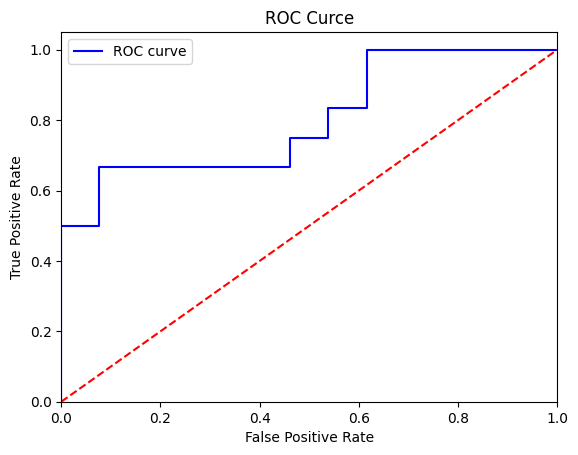

In [7]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, prediction_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue',  label='ROC curve')
plt.plot([0, 1], [0, 1], color='red',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curce')
plt.legend()
plt.show()